<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Modelos ARIMA</font></b></strong>

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib  3.3.0
statsmodels 0.11.1
numpy       1.16.6
sklearn     0.23.1
pandas      1.0.5
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
dataframe.dtypes

QT_INTER    int64
dtype: object

In [6]:
dataframe.shape

(556, 1)

In [7]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [8]:
# Random seed 
np.random.seed(7)

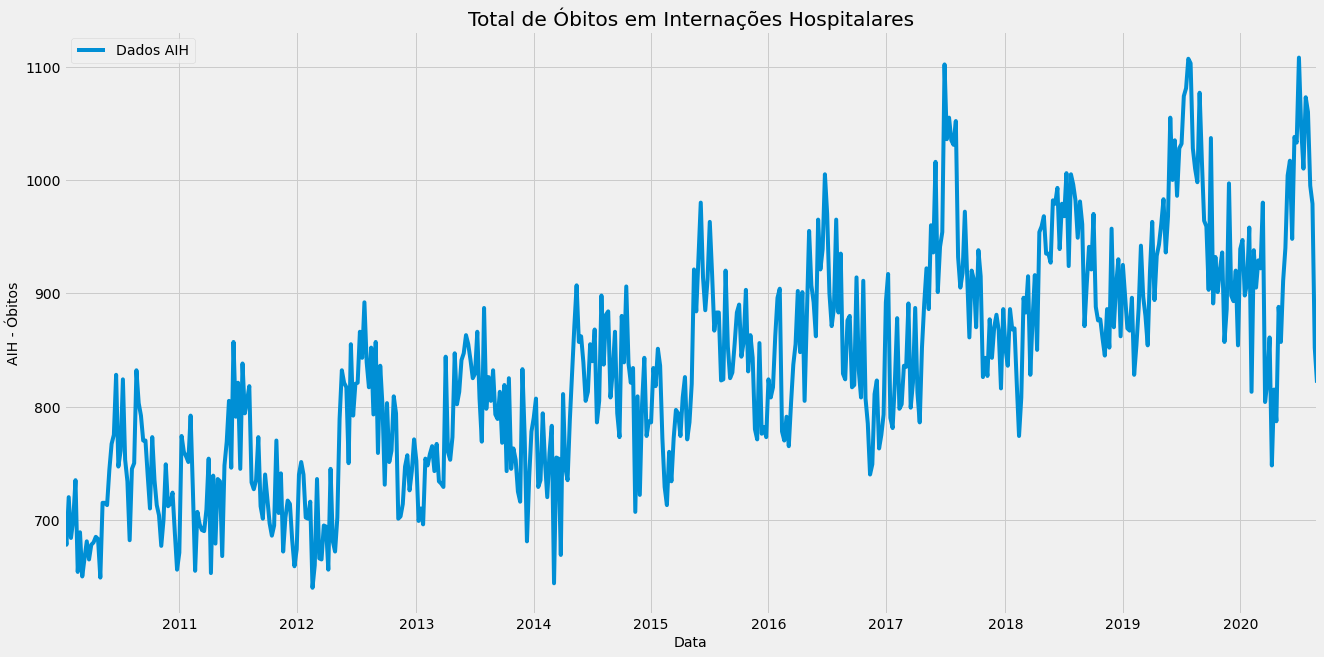

In [9]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


Para Modelos ARIMA, devemos remover a tendência. Vamos fazer isso.

In [11]:
# Aplicando transformação de log
treino_log = np.log(treino) 

In [12]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
teste_log = np.log(teste)

Vamos testar a estacionaridade da série.

In [13]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

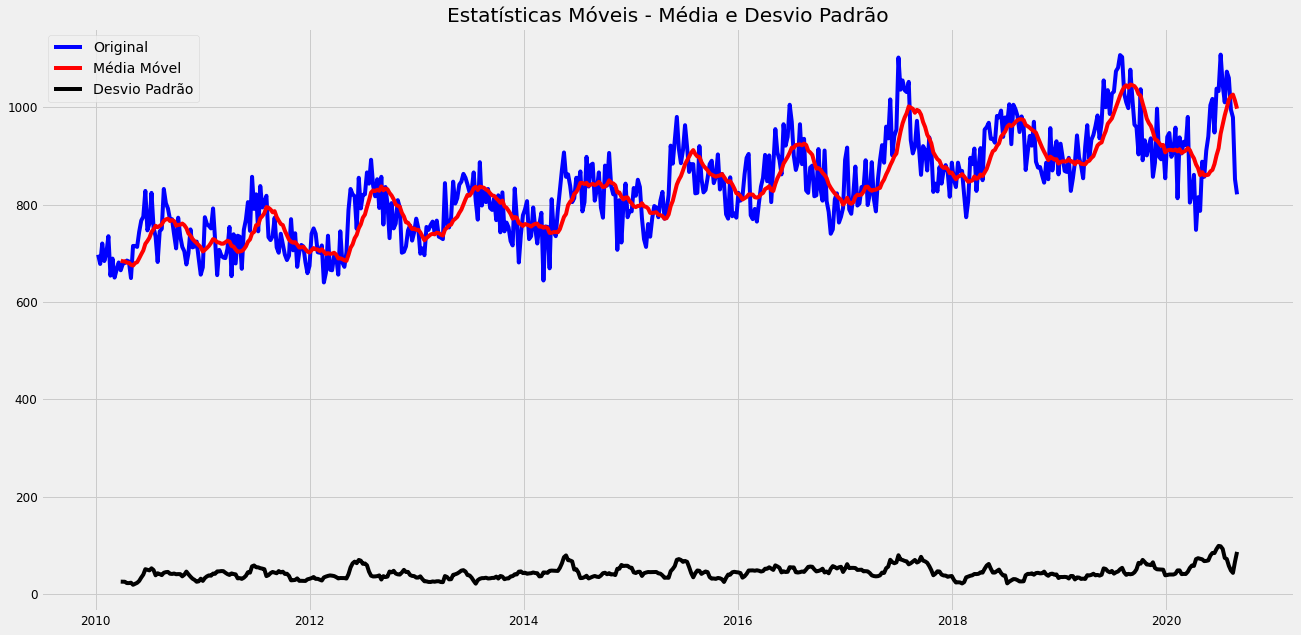


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.631458e+00
Valor-p                         5.701116e-09
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    5.550000e+02
Valor Crítico (1%)             -3.442187e+00
Valor Crítico (5%)             -2.866762e+00
Valor Crítico (10%)            -2.569551e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [14]:
# Aplica a função 
testa_estacionaridade(dataframe['QT_INTER'])


O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd'. Ou seja, d = 0 no Modelo ARIMA.

Você rejeitará a hipótese nula e poderá inferir que a série temporal É ESTACIONÁRIA.

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nos modelos seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [15]:
# Cria o Modelo ARIMA

# Definimos:

# p = 1
# d = 0
# q = 1

# Aqui o valor q é zero, pois é apenas o modelo AR. Nas próximas aulas eu explico porque.

# Modelo
modelo_AR = ARIMA(treino_log, order = (1, 0, 1))

Você pode estar se perguntando: Mas por que usamos os dados originais aqui? Não deveríamos usar a série diferenciada? 

De forma bem clara e objetiva, a resposta é: Não. 

Realizamos todas essas etapas de diferenciação e outras transformações para descobrir os coeficientes do modelo ARIMA. 

'I' no ARIMA significa Integração, que leva em consideração o número de dados diferenciados necessários para se tornar a série estacionária (ou seja, o Modelo ARIMA faz todo o trabalho). 

Realizamos essas etapas de diferenciação no início para encontra o valor ideal de "I". De fato, você deve comparar modelos diferentes com valores diferentes dessas variáveis para obter o melhor modelo.

O Pré-Processamento que fazemos nas séries temporais é para encontrar os melhores valores de p, d e q que colocamos aqui: order = (1, 0, 1).

Portanto, treinamos o modelo com TODOS os dados, a série inteira (dados de treino). Estudaremos isso nas aulas seguintes. 

In [16]:
# Treinamento
modelo_v1 = modelo_AR.fit(disp = -1)  

Vamos fazer previsões com o modelo.

In [17]:
# Sumário do Modelo - Nas próximas aulas vamos interpretar esse sumário do modelo
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               QT_INTER   No. Observations:                  417
Model:                     ARMA(1, 1)   Log Likelihood                 610.341
Method:                       css-mle   S.D. of innovations              0.056
Date:                Wed, 25 Nov 2020   AIC                          -1212.682
Time:                        16:23:46   BIC                          -1196.550
Sample:                    01-10-2010   HQIC                         -1206.304
                         - 12-31-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.6754      0.032    211.587      0.000       6.614       6.737
ar.L1.QT_INTER     0.9627      0.015     64.066      0.000       0.933       0.992
ma.L1.QT_INTER    -0.5459      0.047    -11.703      0.000      -0.637      -0.455
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0387           +0.0000j            1.0387            0.0000
MA.1            1.8317           +0.0000j            1.8317            0.0000
-----------------------------------------------------------------------------
"""

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

In [18]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste_log), alpha = 0.05) 

In [19]:
# Previsões
fc

array([6.75334661, 6.75044237, 6.7476464 , 6.74495465, 6.74236323,
       6.73986842, 6.73746661, 6.73515432, 6.73292823, 6.73078512,
       6.7287219 , 6.72673559, 6.72482332, 6.72298233, 6.72120997,
       6.71950368, 6.71786099, 6.71627953, 6.71475703, 6.71329128,
       6.71188017, 6.71052166, 6.70921379, 6.70795467, 6.70674249,
       6.70557549, 6.704452  , 6.70337038, 6.70232908, 6.7013266 ,
       6.70036149, 6.69943236, 6.69853786, 6.6976767 , 6.69684765,
       6.69604949, 6.6952811 , 6.69454134, 6.69382916, 6.69314353,
       6.69248345, 6.69184798, 6.6912362 , 6.69064723, 6.6900802 ,
       6.68953432, 6.68900878, 6.68850284, 6.68801575, 6.68754682,
       6.68709537, 6.68666075, 6.68624233, 6.68583951, 6.6854517 ,
       6.68507835, 6.68471892, 6.68437289, 6.68403975, 6.68371903,
       6.68341027, 6.68311302, 6.68282684, 6.68255134, 6.6822861 ,
       6.68203076, 6.68178493, 6.68154826, 6.68132042, 6.68110107,
       6.68088989, 6.68068659, 6.68049087, 6.68030244, 6.68012

In [20]:
# Erro
se

array([0.05589065, 0.06055097, 0.06457068, 0.06808471, 0.07118691,
       0.07394603, 0.07641437, 0.07863297, 0.08063476, 0.0824467 ,
       0.08409122, 0.08558721, 0.08695077, 0.08819574, 0.08933414,
       0.09037644, 0.09133186, 0.09220855, 0.09301371, 0.09375379,
       0.09443454, 0.09506114, 0.09563823, 0.09617   , 0.09666025,
       0.09711243, 0.09752965, 0.09791476, 0.09827034, 0.09859876,
       0.09890218, 0.09918258, 0.09944175, 0.09968136, 0.09990292,
       0.10010784, 0.10029739, 0.10047275, 0.10063501, 0.10078517,
       0.10092414, 0.10105277, 0.10117184, 0.10128208, 0.10138415,
       0.10147865, 0.10156617, 0.10164721, 0.10172227, 0.10179178,
       0.10185617, 0.10191581, 0.10197105, 0.10202223, 0.10206964,
       0.10211356, 0.10215425, 0.10219195, 0.10222688, 0.10225924,
       0.10228923, 0.10231701, 0.10234276, 0.10236661, 0.10238872,
       0.1024092 , 0.10242818, 0.10244577, 0.10246207, 0.10247717,
       0.10249117, 0.10250414, 0.10251616, 0.1025273 , 0.10253

In [21]:
# Coeficientes
conf

array([[6.64380294, 6.86289027],
       [6.63176465, 6.86912009],
       [6.62109019, 6.8742026 ],
       [6.61151108, 6.87839822],
       [6.60283945, 6.88188701],
       [6.59493687, 6.88479997],
       [6.58769718, 6.88723603],
       [6.58103653, 6.88927211],
       [6.57488701, 6.89096945],
       [6.56919256, 6.89237769],
       [6.56390614, 6.89353766],
       [6.55898774, 6.89448344],
       [6.55440295, 6.89524369],
       [6.55012186, 6.89584281],
       [6.54611828, 6.89630166],
       [6.54236911, 6.89663824],
       [6.53885383, 6.89686815],
       [6.53555411, 6.89700496],
       [6.53245351, 6.89706055],
       [6.52953723, 6.89704533],
       [6.52679186, 6.89696847],
       [6.52420525, 6.89683807],
       [6.52176631, 6.89666126],
       [6.51946494, 6.8964444 ],
       [6.51729187, 6.8961931 ],
       [6.51523863, 6.89591235],
       [6.5132974 , 6.89560659],
       [6.51146099, 6.89527978],
       [6.50972276, 6.89493541],
       [6.50807658, 6.89457663],
       [6.

In [22]:
# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste_log.index)
limite_inferior = pd.Series(conf[:, 0], index = teste_log.index)
limite_superior = pd.Series(conf[:, 1], index = teste_log.index)

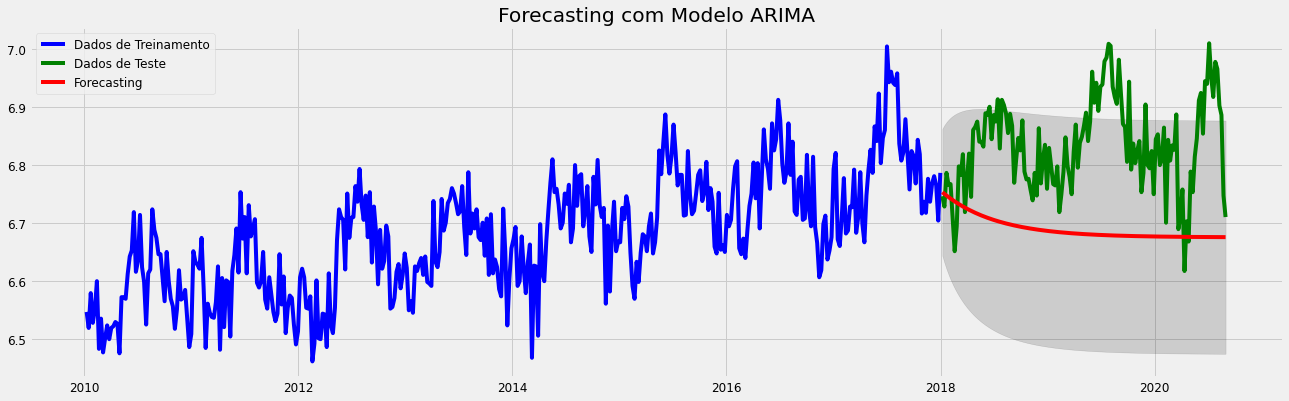

In [23]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino_log, label = 'Dados de Treinamento', color = 'blue')
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

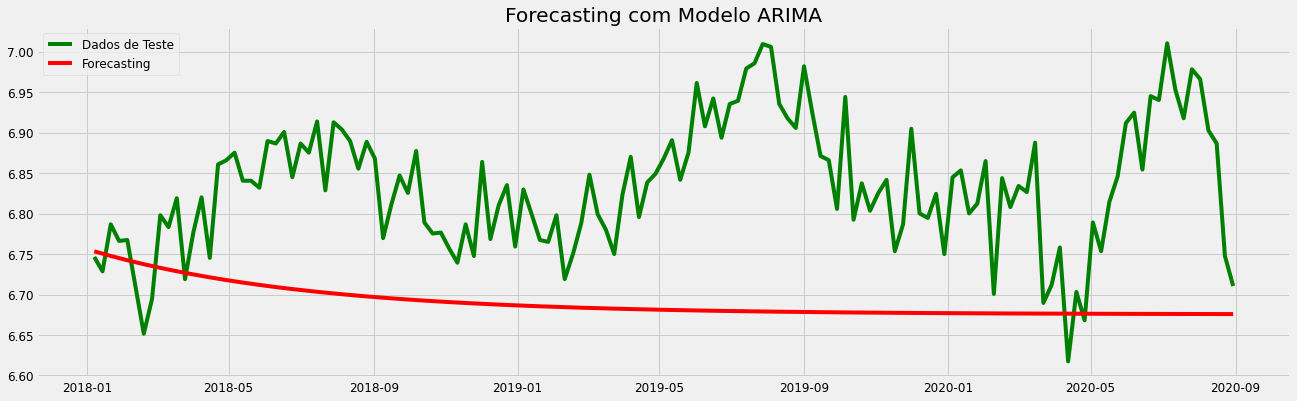

In [24]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série! Nosso modelo está muito bom e poderia ser usado para resolver nosso problema de negócio.


In [25]:
# Define valor real e valor previsto
y_true = teste_log
y_pred = fc_series

In [26]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.16693158224119484


In [27]:
# Define valor real e valor previsto invertendo o LOG
y_true = np.exp(teste_log)
y_pred = np.exp(fc_series)

In [28]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

149.245284352192


Não reduzimos o erro do nosso modelo. 

Reduzimos de 86.177 (naive) para 76.6730 (previsoes_v2 modelo 12) e aumentamos para 149.2452 (modelo 13).

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim